# CH03_分类

## 准备工作

In [42]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

**获取数据集**

In [43]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

* DESCR键，描述数据集
* data键，包含一个数组，每个数组为一行，每个特征为一列
* target键，包含一个带有标记的数组

In [44]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [45]:
y.shape

(70000,)

共有7万张图片，每张图片有`784`个特征。因为图片是`28*28`像素，每个特征代表了一个像素点的强度，从0（白色）到255（黑色）。  
先看一下数据集中的一个数字。只需随机抓取一个实例的数字特征，将其重新形成一个`28*28`数组，再使用`Matplotlib`中的`imshow()`函数显示

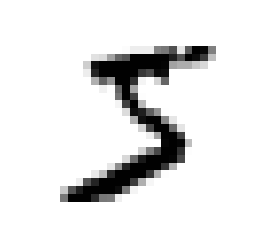

In [46]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [47]:
y[0]

'5'

In [48]:
y = y.astype(np.uint8)

In [49]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [50]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure 更多的数字图像


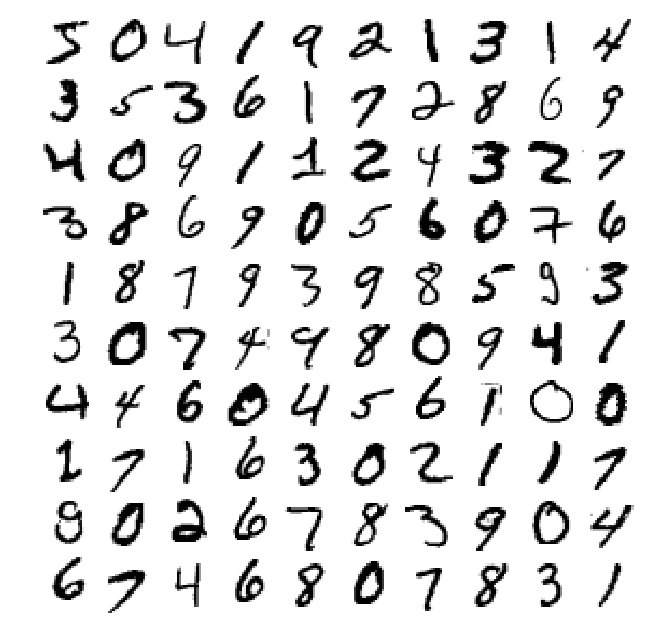

In [51]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("更多的数字图像")
plt.show()

**创建测试集**

In [52]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

将训练集数据洗牌，这样能保证交叉验证时所有的折叠都差不多（避免所有折叠都不会丢失数字）。此外，有些机器学习算法对训练实例的顺序铭感，如果连续输入许多相似的实例，可能导致执行性能不佳。但是对于时间序列的数据（股票数据，天气数据）不适合清洗。

In [53]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二元分类器

现在，先简化问题，只尝试识别一个数字（比如数字5），那么这就是一个区分两个类别：5和非5的二元分类器的例子。

先为此分类任务创建目标向量：

In [54]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

接着挑选一个分类器开始训练。一个好的初始选择是随机梯度下降（`SGD`）分类器，使用`Scikit-Learn`的`SGDClassifier`类即可。这个分类器的优势是，能够有效处理非常大型的数据集。这部分是因为`SGD`独立处理训练实例。（这也是的`SGD`非常适合在线学习）

In [55]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

SGDClassifier在训练时是完全随机的。如果你希望得到可复现的结果，需要设置参数random_state。

In [56]:
# 现在用它来检测数字5的图像
sgd_clf.predict([some_digit])# some_digit是第36000个数字，是9，判断是False

array([ True])

In [57]:
# 第0个数字是5，判断是True
print(sgd_clf.predict([X[0]]))
print(y[0])

[ True]
5


## 性能考核

评估分类器比评估回归器要困难得多。

### 使用交叉验证测量精度

用`cross_val_score()`函数来评估`SGDClassifier`模型，采用`K-fold`交叉验证法，3个折叠。

In [58]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9681 , 0.95655, 0.95515])

所有折叠交叉验证的准确率超过95%？，看起来准确度很高，但再看一个蠢笨的分类器，它将每张图都分类成“非5”

In [59]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [60]:
# 看一下准确度
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

准确率超过了90%，所以如果你猜一个数不是5，90%的时间你都是对的。

**这说明准确率通常无法成为分类器的首要性能指标，特别是当你处理偏斜数据集的时候（即某些类比其他类更为频繁）**

### 混淆矩阵

评估分类器更好的方法是混淆矩阵。总体思路就是统计A类别实例被分成B类别的次数。例如，要想知道分类器将数字3和数字5混淆多少次，只需要通过混淆矩阵的第5张第三列来查看

要计算混淆矩阵，需要先有一组预测才能将其与实际目标进行比较（测试集要留在最后用）。可以使用`cross_val_predict()`函数来完成。

In [61]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

与`cross_val_score()`函数一样，`cross_val_predict()`函数同样执行`K-fold`交叉验证，但返回的不是**评估分数**，而是每个折叠的**预测**。这意味着对于每个实例可以得到一个“干净”的预测（“干净”是指模型预测时使用的数据，在其训练期间从未见过）

现在，可以使用`confusion_matrix()`函数来获取混淆矩阵。只需要给出目标类别（`y_train_5`）和预测类别（`y_train_pred`）

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

书上解释：混淆矩阵中的**行表示实际类别，列表示预测类别**。本例中第一行表示所有“非5”（负类）的图片中，53124张被正确地分为“非5”类别（真负类），1455张被错误地分类成了“5”（假正类）；第二行表示所有“5”（正类）的图片中，949张被错误的分为“非5”类别（假负类），4472张被正确的分为“5”类别（真正类）。

**一个完美的分类器只有真正类和真负类，所以他的混淆矩阵只会在其对角线上有非零值。**

In [63]:
# 模拟一个完美的分类器
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

混淆矩阵能提供大量信息，但有时你可能希望指标更简洁一些。正类预测的准确率是一个有意思的指标，也被称为分类器的**精度**：

<center>precision $=\frac{T P}{T P+F P}$</center>

TP表示真正类的数量，FP表示假正类的数量

做一个单独的正类预测，并确保它是正确的，就可以得到完美精度（精度=1/1=100%），但这没有什么意义，因为分类器会忽略这个正类实例之外的所有内容。因此，精度通常与另一个指标，即**召回率**，一起使用。召回率也称为**灵敏度**，或者**真正类率**。它是分类器正确检测到的正类实例的比率：

<center>recall $=\frac{T P}{T P+F N}$</center>

FN表示假负类的数量

通过一张图更好地理解混淆矩阵：
![图解混淆矩阵](./images/confusion_matrix.png)

* 精度：（例如4个对了3个）
* 召回率：（例如5个里找出了3个）

个人理解：
* 真正类（TP）：确实是真的，“5“被识别成了“5“
* 真负类（TN）：确实是假的，“非5”被识别成了“非5”
* 假正类（FP）：不是真正的正类，“非5”被识别成了“5”
* 假负类（FN）：不是真正的负类，“5”被识别成了“非5”


### 精度和召回率

`Scikit-Learn`提供了计算多种分类器指标的函数，精度和召回率也是其中之一：

In [64]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4472 / (4472 + 1455)

0.754513244474439

In [65]:
recall_score(y_train_5, y_train_pred)

0.8249400479616307

从精度和召回率上来看。当它说一张图是5时，只有75%的时间是准确的，并且也只有82%的数字5被它检测出来了。

因此可以将精度和召回率组合成一个指标：$F_{1}$，当需要一个简单的指标比较两种分类器时，这是一个非常不错的指标。$F_{1}$是精度和召回率的谐波平均值。（正常平均值会平等对待所有的值，但是谐波平均值会给予较低的值更高的权重。因此，只有当召回率和精度都比较高时，分类器才能得到较高的$F_{1}$分数）

<center>$F_{1}=\frac{2}{\frac{1}{\text { precision }}+\frac{1}{\text { recall }}}=2 \times \frac{\text { precision } \times \text { recall }}{\text { precision }+\text { recall }}=\frac{T P}{T P+\frac{F N+F P}{2}}$</center>

为了得到$F_{1}$分数，可以使用`f1_score()`函数

In [66]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7881565033486078

$F_{1}$分数对那些具有相近的精度和召回率的分类器更为有利。

在不同的场景下，关心精度和召回率的程度不一样。如：在一个检测儿童可以放心观看的视频分类器中，想要一个低召回率，高精度的分类器。在一个图像监控检测小偷的分类器中，想要一个高召回率，精度可以稍微低一点的分类器

但往往并不能同时增加精度又减少召唤率，这称为精度/召唤率权衡。

### 精度/召唤率权衡

要理解这个权衡的过程，先来看看`SGDClassifier`如何进行分类决策的。对于每个实例，它会基于决策函数计算出一个分值，如果该值大于阈值，则该实例判为正类，否则便将其判为负类。

![决策阈值和精度/召唤率权衡](./images/thresholds.png)

从图中可以看出，当阈值设置为两个5之间时：在阈值右侧可以找到4个真正类（真的5），一个假正类（实际上是6）。因此，在该阈值下，精度为80%（4/5），但是在6个真正的5中，分类器仅检测到了4个，所以召回率是67%（4/6）。

现在，如果提高阈值（将其挪动到右边箭头的位置），假正类（数字6）变成了真负类，因此精度得到了提升，但是一个真正类变成了一个假负类，召回率降低至50%。反之，降低阈值则会在增加召回率的同时降低精度。

`Scikit-Learn`不允许直接设置阈值，但是可以访问它用于预测的**决策分数**。不是调用分类器的`predict()`方法，而是调用`decision_function()`方法，这个方法返回每个实例的分数，然后根据这些分数，使用任意阈值进行预测了。

In [67]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3251.81547403])

In [68]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

`SGDClassifier`分类器使用的阈值是0，所以前面的代码返回结果与`predict()`方法一样。

In [69]:
# 提升阈值
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

这证明了提高阈值确实可以降低召回率。这张图确实是5，当阈值是0时，分类器可以检测到该图，但是当阈值提高到200000时，就错过了这张图。

要想决定使用什么阈值时，首先，使用`cross_val_predict()`函数获取训练集中所有实例的分数，但是这次需要它返回的是**决策分数**而不是预测结果。（类似于`decision_function()`函数）

In [70]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-18922.19789678,  -9437.14784295,  -2464.76484921, ...,
        -7512.63380148, -16501.63029593, -16429.11305816])

有了这些分数，可以使用`precision_recall_curve()`函数来计算所有可能的阈值的精度和召回率。

In [71]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure SGD_精度和召回率vs决策阈值


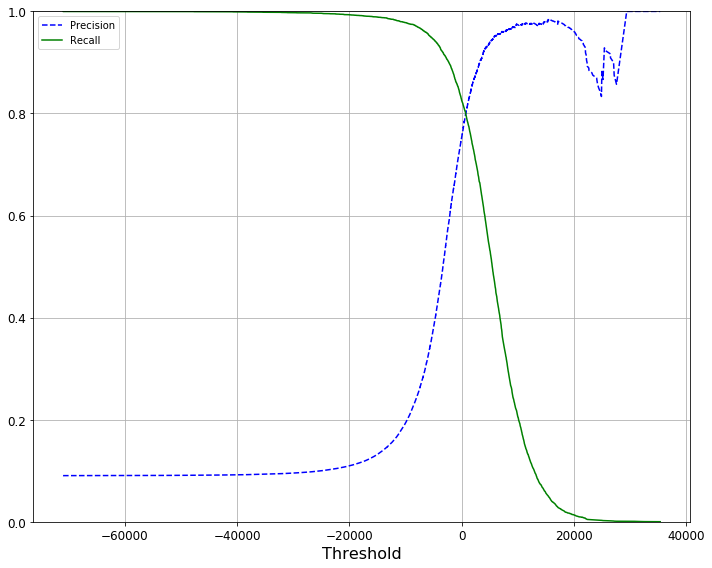

In [72]:
# 使用matplotlib绘制精度和召回率相对于阈值的函数图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("SGD_精度和召回率vs决策阈值")
plt.grid()
plt.show()

从图中可以看出，精度曲线要崎岖一些，原因在于当提高阈值时，精度有时也有可能会下降（尽管总体趋势是上升的），就像阈值图中所示，当阈值从中间箭头往右移动一位数时，精度从4/5（80%），下降到3/4（75%）。另一方面，当阈值上升时，召回率只会下降。

现在，可以从图中轻松选择阈值来实现最佳的精度/召回率权衡了。还有一种找到好的精度/召回率权衡的方法是直接绘制精度和召回率的函数图。

Saving figure SGD_精度vs召回率


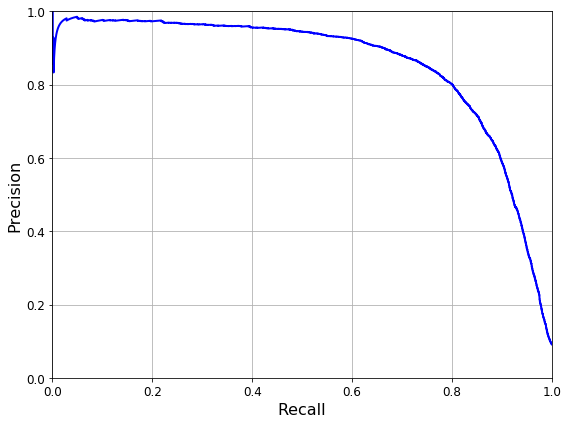

In [73]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("SGD_精度vs召回率")
plt.show()

从图中可以看出，从80%召回率往右，精度急剧下降。

假设准备选择90%精度。通过绘制的第一张图，得出需要使用的阈值大概是3500。可以通过以下代码预测。

In [74]:
y_train_pred_90 = (y_scores > 3500)

检查以下这些预测结果的精度和召回率

In [75]:
precision_score(y_train_5, y_train_pred_90)

0.9063719115734721

In [76]:
recall_score(y_train_5, y_train_pred_90)

0.6428703191293119

现在有了一个90%精度的分类器了。虽然只要阈值足够高，就能有高的精度。但是，阈值高了，召回率很低的话，其实也没什么用！

### ROC曲线

还有一种与二元分类器一起使用的工具，叫做受试者工作特征曲线（`ROC`），它与精度/召回率非常相似，但绘制的不是精度和召回率，而是**真正类率**（召回率的另一名称）和**假正类率**（`FPR`）。`FPR`是被错误分为正类的负类实例比率。它等于1减去**真负类率**（TNR），后者是被正确分类为负类的负类实例比率，也称为**异度率**。因此`ROC`曲线绘制的是**灵敏度**和**（1-异度率）**的关系

要绘制`ROC`曲线，首先需要使用`roc_curve()`函数计算多种阈值的`TPR`和`FPR`

In [77]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

然后使用`Matplotlib`绘制`FPR`对`TPR`的曲线。

In [78]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1],[0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Saving figure SGD_ROC曲线


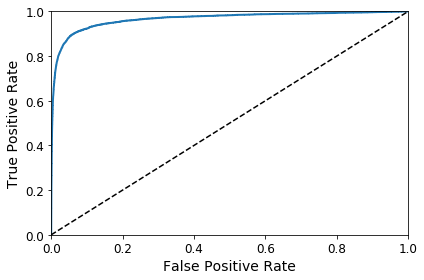

In [79]:
plot_roc_curve(fpr, tpr)
save_fig("SGD_ROC曲线")
plt.show()

从图中可以看出，召回率（`TPR`）越高，分类器产生的假正类（`FP`）就越多。虚线表示纯随机分类器的`ROC`曲线，一个优秀的分类器应该离这条虚线越远越好（向左上角）。

有一种比较分类器的方法是测量曲线下面积（`AUC`）。完美的分类器的`ROC AUC`等于1，而纯随机分类器的`ROC AUC`等于0.5。`Scikit-Learn`提供计算`ROC AUC`的函数。

In [80]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9660259463088996

由于`ROC`曲线和精度/召回率（`PR`）曲线非常相似，因此在决定使用哪种曲线的时候有下面的经验法则：

当**正类非常少见**或者**更关注假正类（精度）而不是假负类（召回率）**的时候，应该选择`PR`曲线，反之则是`ROC`曲线。

例如，在本例中，使用`ROC`曲线或者`ROC AUC`分数，可能觉得这个分类器很不错，但是相比之下，`PR`曲线表现出该分类器还有改进的空间（曲线还可以更接近右上角）。因为该例中正类（数字5）的数量比较少，使用`PR`曲线比较合适。